# FRI承诺基本原理

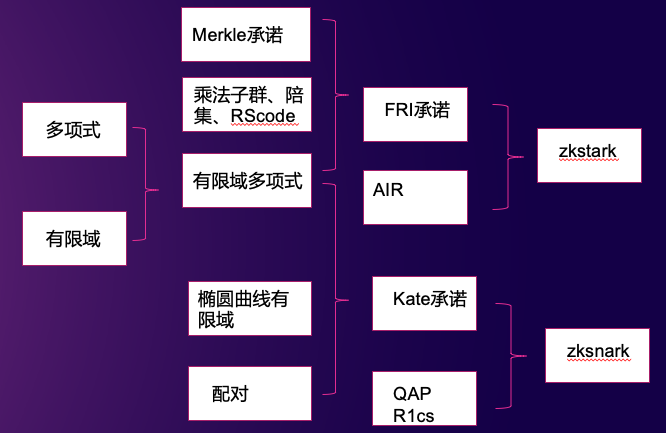

FRI，即 Fast RS IOPP，全称 Fast Reed-Solomen Interactive Oracle Proofs of Proximity，是一种更有效的 proximiary 测试方法，测试一个点的集合大部分是在一个度小于某个值的多项式上，能达到线性级的证明复杂度和对数级的验证复杂度。其中RSCode是一种容错编码方式，设$\rho$ 为码率，通常为$ 2^{-R}$，其中R为正整数，例如当$\rho = \frac{1}{8} $ 时，意味着有 $\frac{7}{8} $ 的码是用于冗余纠错的。在stark101  https://github.com/starkware-industries/stark101 的代码里，对应的就是，先在一个大小为1024的子群里利用拉格朗日差值求出 $f(x)$，然后在一个大小为8192的陪集里提交承诺和验证。

## RScode基本原理

RScode是在信息学的编码理论，其基本原理如下：<br>
我们知道在多项式插值中，如果二维平面上有$k$个点，我们可以通过拉格朗日插值（Lagrange interpolation）找到最高次幂不超过$k-1$的多项式 $\sum_{i=0}^{k-1} a_i*x^{i} $。写成矩阵的形式如下

$$\begin{bmatrix}
1 & x_0 & \cdots & x_0^{k-1}\\
1 & x_1 & \cdots & x_1^{k-1}\\
\vdots  & \vdots & \ddots & \vdots \\
1 & x_{k-1} & \cdots & x_{k-1}^{k-1}\\
\end{bmatrix} . \begin{bmatrix}
a_0 \\
a_1 \\
\vdots \\
a_{k-1} \\
\end{bmatrix} = \begin{bmatrix}
y_0 \\
y_1 \\
\vdots \\
y_{k-1} \\
\end{bmatrix}$$


记上述方阵为 $V_{k*k} $ ，实际上此矩阵为Vandermonde矩阵，由于其方阵行列式为
$$ det(V_{k*k}) = \prod_{}(x_j - x_i) $$


因此当$x_i, x_j $两两不同时，此方阵可逆。

于是多项式系数 $f(x) $ 可以得出
$$ \begin{bmatrix}
a_0 \\
a_1 \\
\vdots \\
a_{k-1} \\
\end{bmatrix} = (V_{k*k})^{-1} \begin{bmatrix}
y_0 \\
y_1 \\
\vdots \\
y_{k-1} \\
\end{bmatrix} $$

基于此，我们可以构造一种编码方案，多项式$f(x)$ 的系数看作需要编码的长度为$k$ 的消息字符串$m=a_0a_1\cdots a_{k-1} $  ，编码消息前，发送方和接收方事先约定好 n个求值点 ${x_0,x_1,x_2,\cdots,x_{n-1}}$  ，发送方通过消息字符串$m$ 构造多项式$f(x)$ ，并计算出 ${f(x_0),f(x_1),f(x_2),\cdots,f(x_{n-1})}$ 。生成长度为$n$的码字$c=f(x_0)f(x_1)f(x_2)\cdots f(x_{n-1}) $ ，接收方收到此码字的任意 $k$ 个字符，都可以通过矩阵乘法求出系数从而还原得到消息。

在FRI中，发送的RS codeword，其实就是verifier要查询的oracle。

## RScode 几种验证方式概述

### testing

一种最直观的做法是，在Verifier(接收端)根据码率 $\rho$ 需要检测 $ k=\rho*n $个码字，以确定是否可以还原，这种做法在密码学里归类为Testing，很显然，这种方法不需要Prover（发送端）提供任何额外的信息，也不存在其它的交互，唯一的缺点是verifier的工作量和Prover完全线性相关的，密码学努力的方向就是争取让verifier的工作量降低几个量级，这在零知识证明里称之为succinct特性。

### PCPP

密码学一个里程碑的贡献是Probabilistically checkable proofs of proximity，作者因此获得了图灵奖，有兴趣可以去搜一下。本文简单描述其原理，就是Prover需要额外提供一个proof，verifier通过查询来判断prover是否作弊。根据不同的场景，这个proof可能是一个椭圆曲线上的公钥，也可能是多项式计算的一个结果。Verifer通过常数次查询，就能概率性判断Prover是否作弊，例如在zksnark里，verifier能通过一次查询就能判断prover的作弊的可能性 $< \varepsilon $. <br>

PCPP一直在发展和优化，具体细节需要跟踪最新的理论研究成果。如果依据FRI的论文数据，FRI相比PCPP有很大的优化空间。

### IOPP

IOPP相比PCPP不同之处在于，其Prover和Verifier有多次交互，从而降低了总Proof的大小，同时也改进了Verifier的工作量。FRI是一个改进版本的IOPP，核心算法思想是类似于FFT（快速傅里叶变换），通过不断降低每轮验证函数的阶，来验证Prover提供的信息非常接近于一个低阶的多项式函数，这也是一个概率性的验证方式，思想跟PCPP如出一辙，只是优化了证明的大小和验证者的工作量。下图是来自于FRI论文里的比较数据。

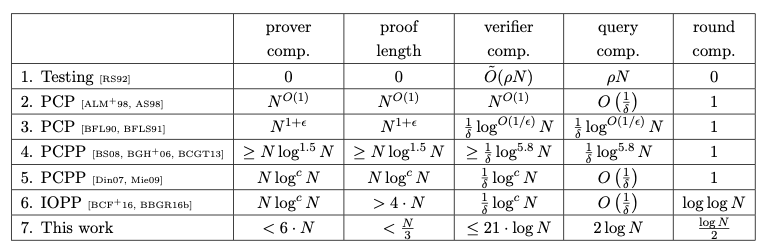

通常意义上的插值(Interpolation)意味着找到一个通过一组数据点的多项式。在STARK的上下文中，插值意味着找到算数约束系统(arithmetic constraint system)的一个多项式表示。The resulting object is not an arithmetic constraint system but an abstract protocol called a Polynomial IOP.

The prover in a regular proof system sends messages to the verifier. But what happens when the verifier is not allowed to read them? 具体的说，如果来自证明者的消息能够被oracles取代(oracle指的是一种验证者可以在他选择的点中查询的抽象黑盒功能),那么协议就是一个 interactive oracle proof (IOP). 当oracles对应低度多项式时, 它是 Polynomial IOP. 直觉就是诚信的prover可以获得一个等式都成立的多项式约束系统，而作弊的prover获得的约束系统中，至少有一个等式是不成立的。当多项式相等时，它们在任何地方都相等，尤其是在验证者选择的随机点上。但是当多项式不相等时，它们几乎处处不相等，并且当验证者在随机点处验证时，这种不相等有极大的概率会暴露出来。

The STARK proof system interpolates the algebraic execution trace literally – 也就是说，它找出 𝑤 个多项式 𝑡𝑖(𝑋), 使得 𝑡𝑖(𝑋) 在域 𝐷 上的取值和 AET 中的第i个寄存器上的值对应. 这些多项式被作为oracle发送给verifier. At this point the AIR constraints give rise to operations on polynomials that send low-degree polynomials to low-degree polynomials only if the constraints are satisfied. 验证者模拟这些操作，因此可以推导出新的多项式，其低度(low degree)证明了约束系统的可满足性，从而证明了计算的完整性。换句话说，插值步骤将算术约束系统的可满足性降低到关于某些多项式的低阶的声明。

## Cryptographic Compilation with FRI
在现实世界中，多项式预言机(polynomial oracles)并不存在。想要使用多项式 IOP 作为中间阶段的协议设计者必须找到一种方法来commit多项式，然后在验证者选择的点打开该多项式。 FRI 是 STARK 证明的关键组成部分，它通过使用 Reed-Solomon Codewords 的 Merkle 树来证明多项式次数的有界性，从而实现了这一任务。

与多项式 𝑓(𝑋)∈F[𝑋] 相关的 Reed-Solomon codeword 是它在给定域 𝐷⊂F 上的值列表. 考虑不失一般性的域 𝐷，其元素个数大于多项式的最大允许次数。这些值可以放入 Merkle 树中，在这种情况下，Merkle树的根代表对多项式的承诺(commitment)。Fast Reed-Solomon IOP of Proximity (FRI) 是一种协议，它的证明者发送一个 Merkle 根序列，对应的codeword在每次迭代中长度减半。验证者检查连续轮次的merkle树（验证merkle path）以测试简单的线性关系。对于诚实的证明者，所表示的多项式的次数同样在每一轮中减半，因此远小于codeword的长度。然而对于恶意证明者来说，这个度数比codeword的长度小一。在最后一步，证明者发送一个与常数多项式相对应的non-trivial codeword。

上面没有提及的一个问题是：验证者如何在不属于域的点 𝑧 处查询一个 committed polynomial 𝑓(𝑋) ? 原则上，有一个明显而直接的解决方案：verifier将 𝑧 发送给prover, prover则响应 𝑦=𝑓(𝑧). 多项式 𝑓(𝑥)−𝑦 在 𝑋=𝑧 处等于0, 因此 𝑓(𝑥)−𝑦 必须被 𝑋−𝑧 整除. 所以证明者和验证者都可以访问一个新的低次多项式 𝑓(𝑋)−𝑦𝑋−𝑧 . 如果prover在 𝑓(𝑧)=𝑦 上撒谎, 那么他就无法证明 𝑓(𝑋)−𝑦𝑋−𝑧 是低度的, 所以他的欺诈行为将在 FRI 协议的过程中暴露出来。This is in fact the exact mechanism that enforces the boundary constraints; a slightly more involved but similar construction enforces the transition constraints. 新的多项式是已知因子相除的结果，因此它们将被称为 商(quotients) 并表示为 𝑞𝑖(𝑋) .

至此，多项式 IOP 已编译为一个交互式具体证明系统。 原则上，该协议是可以执行的。 然而，多做一步加密编译是值得的：用伪随机(但具有确定性)的东西替换验证者的随机硬币（随机性）。 这正是 Fiat-Shamir 变换，其结果是称为 STARK 的非交互式证明。

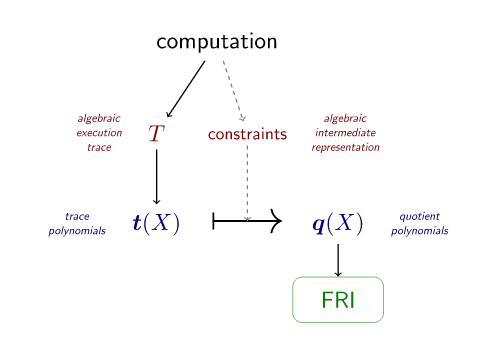